In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm
import concurrent.futures

print(os.listdir())
import matplotlib.pyplot as plt

['youtube.ipynb', 'shaded.png', 'sampling_test.ipynb', 'social_to_adjacency.ipynb', '.ipynb_checkpoints', 'twitch.ipynb', 'musae_facebook_edges.csv', 'Figures', 'social_to_ds.ipynb', 'large_twitch_edges.csv', 'cleaner_algorithm.ipynb', 'nb_class_assignment.ipynb', '.DS_Store', 'artist_edges.csv']


In [2]:
parent_directory = os.path.dirname(os.getcwd())
data_directory   = os.path.join(parent_directory, "raw_datasets/facebook_large")

In [3]:
filename = "musae_facebook_edges.csv"
dataset_path = os.path.join(data_directory, filename)

social_data = pd.read_csv(dataset_path, delimiter = ",", skiprows = 0)
print(social_data.shape)
# np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")
social_data.head()

(171002, 2)


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
target_filename = "musae_facebook_target.csv"
target_path     = os.path.join(data_directory, target_filename)

target_data = pd.read_csv(target_path, delimiter = ",", skiprows = 0)
target_data.head()

node_ids = target_data["id"].tolist()
page_types = target_data["page_type"].tolist()


classes = np.unique(page_types)
int_labels = [i for i in range(classes.shape[0])]

conv_dict = {}
for i, page_type in enumerate(list(classes)):
    conv_dict[page_type] = int_labels[i]
    
print(conv_dict)

int_labels = {}

for i, item in enumerate(page_types):
    int_labels[str(i)] = conv_dict[item]

{'company': 0, 'government': 1, 'politician': 2, 'tvshow': 3}


In [5]:
import json

attribute_filename = "musae_facebook_features.json"
attribute_path     = os.path.join(data_directory, attribute_filename)

with open(attribute_path, "r") as f:
    attribute_data = json.load(f)
    
attribute_shape = len(attribute_data["15"])

keys = list(attribute_data.keys())
lengths = [len(attribute_data[l]) for l in keys]
tokens = []
for k in keys:
    tokens += attribute_data[k]
print(np.unique(lengths))
print(np.min(tokens))
print(np.max(tokens))

def feature_to_token(feature, min_t = 0, max_t = 4800):
    out_vector = np.zeros(max_t)
    out_vector[feature] = 1
    return out_vector

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 19 20 21 22 23 24 25 26 27 28 29
 30 31]
0
4713


In [6]:
columns = list(social_data.columns)
print(columns)

G = nx.from_pandas_edgelist(social_data, columns[0], columns[1], create_using = nx.Graph)

for i, node in enumerate(list(G.nodes)):
    
    G.nodes[node]["target"] = int_labels[str(node)]
    # G.nodes[node]["attribute"] = features[i,:]
    # print(features[i,:])

['id_1', 'id_2']


In [7]:
G = nx.convert_node_labels_to_integers(G)

(171002, 2)
22470
500
500


  0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]

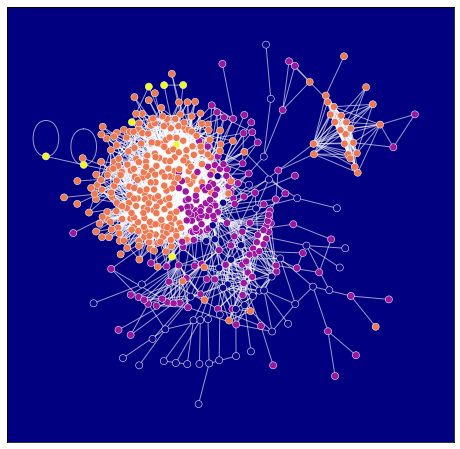

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]


In [36]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 1

graph_ind_array = np.zeros(n_nodes)
min_per_graph = 499
n_per_graph = 500#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs



print(total_n)
graph_ind_array = np.zeros(total_n)

graphlist = []
#number_of_nodes = int(0.5*graph.number_of_nodes())

offset_index = 0
for i in tqdm(range(n_graphs)):
    
    
    sampler = ForestFireSampler(number_of_nodes = np.random.randint(min_per_graph, n_per_graph), #n_per_graph,#
                               seed = np.random.randint(1, 1e9))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    node_labels_g = [new_graph.nodes[n]["target"] for n in new_graph.nodes]
    # node_attrs_g = [new_graph.nodes[n]["attribute"] for n in new_graph.nodes]
    
    graphlist.append(new_graph)
    
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
        node_labels = np.array(node_labels_g)
        # node_attrs = np.array(node_attrs_g)
        
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
        node_labels = np.append(node_labels, node_labels_g)
        # node_attrs = np.append(node_attrs, node_attrs_g, axis = 0)
    
    if i % 50 == 0:
        # print(node_attrs.shape)
        # print(node_attrs.shape[0]/n_per_graph)
        
        fig, ax = plt.subplots(figsize = (8,8))
        
        # pos = nx.spring_layout(
        #   new_graph, k=0.1, iterations=100)
        
        pos = nx.kamada_kawai_layout(new_graph)
        
        
        colors = []
        
        for g in new_graph.nodes:
            colors.append(new_graph.nodes[g]["target"])
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=50,
          node_color=colors,
          alpha=1,
          linewidths=0.5,
          edgecolors = "white",
          cmap = "plasma",
          ax = ax)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.6, width=1, ax = ax, edge_color = "white", connectionstyle='arc3,rad=0.5')
        
        # ax.set_facecolor('navy')

        plt.savefig(f"Figures/graph_example{i}.jpg", dpi = 400)
        plt.show()
    offset_index += len(nodes)

total_n = graph_ind_array.shape[0]

In [9]:
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

def nearest_similar_node(G, n, labels):
    nodelist = list(G.nodes)
    class_match_distance = {}
    
    nodes_by_class = {}
    for l in labels:
        for n2 in nodelist:
            node = G.nodes[n2]
            if "target" in node and n != n2:
                
                if node["target"] not in nodes_by_class:
                    nodes_by_class[node["target"]] = [n2]
                else:
                    nodes_by_class[node["target"]].append(n2)
    
    for c in nodes_by_class:
        paths = [nx.shortest_path_length(G, source = n, target = n2) for n2 in nodes_by_class[c]]
        shortest = np.min(paths)
        class_match_distance[c] = shortest
    return class_match_distance
        
    
def calculate_probability_by_degree(G, ax = None, max_degree = None, labels = None, kernel = 5):

    
    classes = []
    all_labels = []
    for n in G.nodes:
        all_labels.append(G.nodes[n]["target"])
        if G.nodes[n]["target"] not in classes:
            classes.append(G.nodes[n]["target"])

    degrees = {}
    for item in classes:
        degrees[item] = []

    for n in list(G.nodes()):
        cl = G.nodes[n]["target"]
        deg = G.degree(n)
        degrees[cl].append(deg)

    labels = list(degrees.keys())

    
    degree_list = [degrees[l] for l in sorted(labels)]

    if max_degree is None:
        max_bin = np.max([np.max(d) for d in degree_list])
        # print(max_bin)
    else:
        max_bin = max_degree
        # print(max_bin)
        
    degree_array = np.zeros((max_bin, len(labels)))
    
    base_probs = [all_labels.count(l) for l in sorted(labels)]
    
    for i, d in enumerate(degree_list):

        count, bins = np.histogram(d, bins = max_bin, range = (0, max_bin))

        degree_array[:, i] = count

    
    for i in range(degree_array.shape[0]):
        sli = degree_array[i,:].tolist()
        if sli == [0,0,0,0]:
            degree_array[i,:] = base_probs#[0.1,0.1,0.1,0.1]
            continue
        for n, d in enumerate(sli):
            if d == 0:
                degree_array[i, n] = 0.1

    for d in range(degree_array.shape[1]):
        degree_array[:,d] = gaussian_filter1d(degree_array[:,d], sigma = kernel)
    
    sum_array = np.sum(degree_array, axis = 1)
    for d in range(degree_array.shape[1]):
        degree_array[:,d] = degree_array[:,d] / sum_array
        
        
    class_to_index = {labels[i]:i for i in range(len(labels))}
    
    
    if ax is not None:
        for i in sorted(labels):
            index = class_to_index[i]
            ax.fill_between(np.arange(degree_array[:,index].shape[0]), degree_array[:,index],
                            zorder = 100/ np.min(degree_array[:,index]),alpha = 0.25)
            ax.plot(np.arange(degree_array[:,index].shape[0]), degree_array[:,index],
                label = f"{i}")#, zorder = 10000)
            # ax.plot(np.arange(degree_array[:,index].shape[0]), np.sum(degree_array, axis = 1))
        ax.legend(shadow = True, loc = "upper left")
        return ax
    
    return degree_array
        
    
    
    

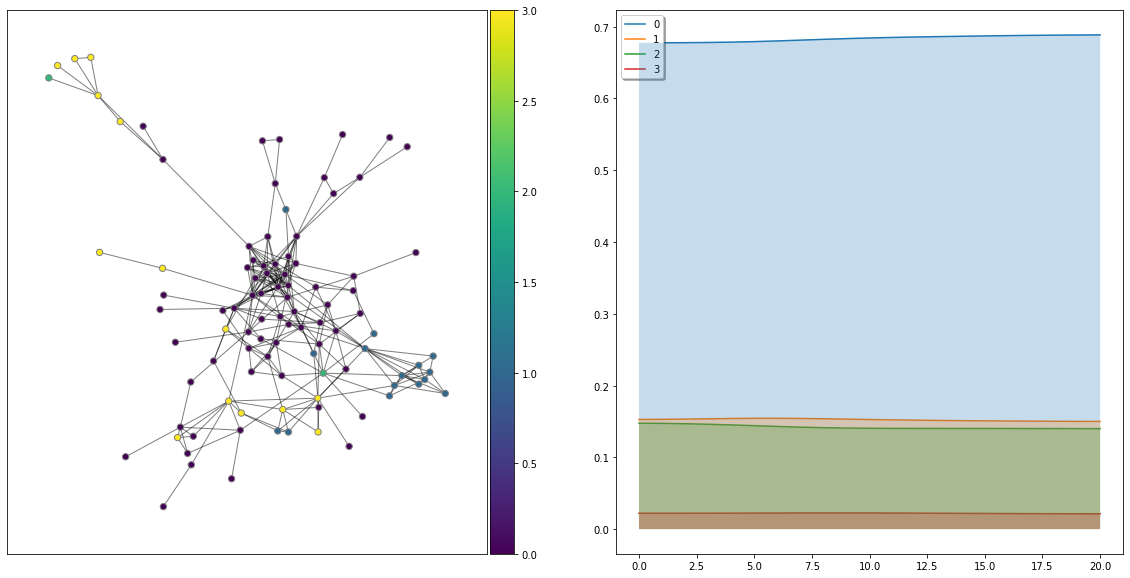

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_colours(G):
    nodelist = list(G.nodes)
    colours = [G.nodes[n]["target"] if "target" in G.nodes[n] else -1 for n in nodelist]
    return colours

def get_labels(G):
    nodelist = list(G.nodes)
    labels = {}
    for n in nodelist:
        labels[n] = G.nodes[n]["target"]
    return labels

def get_legend(G):
    nodelist = list(G.nodes)
    colours = [G.nodes[n]["target"] for n in nodelist]
    labels = np.unique(colours).tolist()
    
    return labels
    
g_sample = graphlist[np.random.randint(0, len(graphlist))]
pos = nx.spring_layout(g_sample, k = 0.1, iterations = 100)


fig, (ax1, ax2)  = plt.subplots(ncols = 2, figsize = (20,10))

im = nx.draw_networkx_nodes(g_sample,pos, node_color = get_colours(g_sample), node_size = 40, ax = ax1, edgecolors = "grey")
# nx.draw_networkx_labels(g_sample,pos, get_labels(g_sample), ax = ax1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax = cax)

nx.draw_networkx_edges(g_sample,pos, node_size = 40, ax = ax1, alpha = 0.5)

ax2 = calculate_probability_by_degree(g_sample, ax2)


0 3
0 1
0 1
0 1
3 1
0 1
3 1
1 0
3 0
3 0
1 0
0 1
0 1
1 0
3 0
2 0
0 3
2 3
3 0
0 3
0 3
0 3
0 3
1 3
0 3
3 0
1 3
0 3
0 1
1 0
1 0
1 0
3 0
1 0
1 0
3 0
2 0
3 0
1 0
2 0
1 0
1 0
1 0
3 0
1 0
1 0
1 0
3 0
0 1
0 3
0 1
1 0
1 0
3 0


KeyError: 'target'

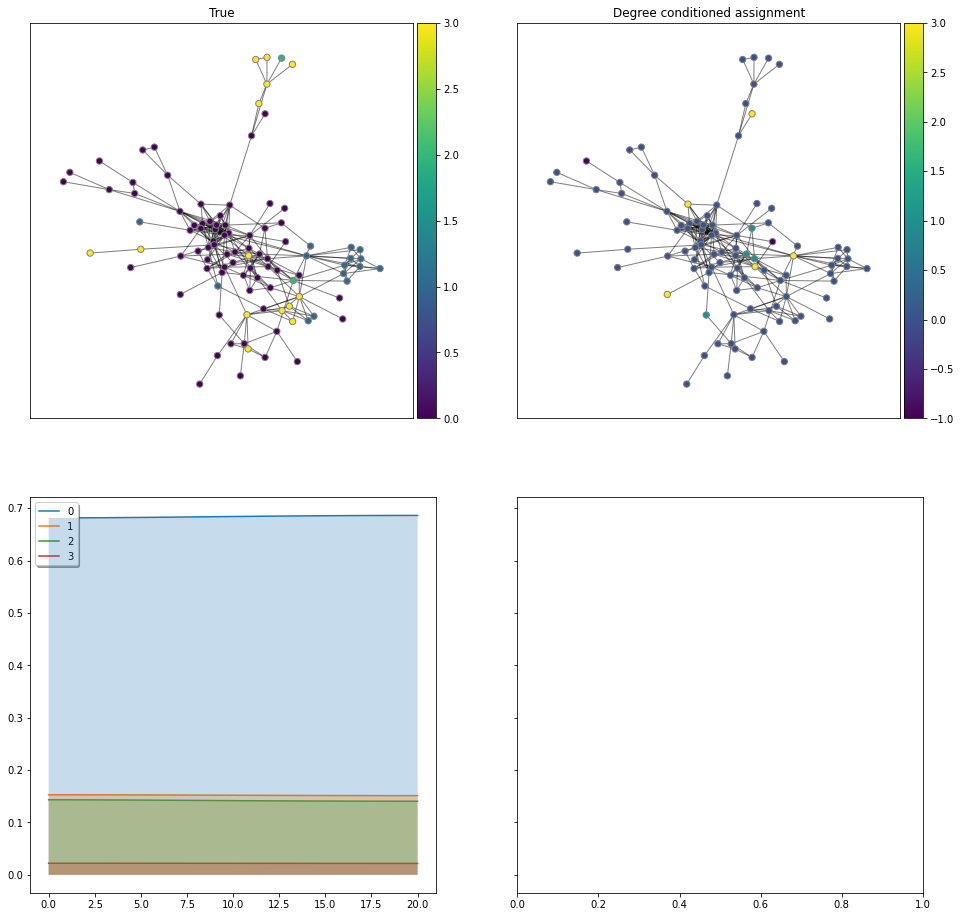

In [11]:
import random
from IPython.display import clear_output
import concurrent.futures
from time import time


def strip_data(G):
    nodelist = list(G.nodes)
    
    for n in nodelist:
        node = G.nodes[n]
        for k in list(node.keys()):
            del G.nodes[n][k]
    return G

def all_class_detail(G):
    return [G.nodes[n]["target"] for n in list(G.nodes) if "target" in G.nodes[n]]

def nearest_class(G, n, shortest_paths, labels):
    nodelist = list(G.nodes)
    class_match_distance = {}
    
    nodes_by_class = {}
    for l in labels:
        for n2 in nodelist:
            node = G.nodes[n2]
            if "target" in node and n != n2:
                
                if node["target"] not in nodes_by_class:
                    nodes_by_class[node["target"]] = [n2]        
                else:
                    nodes_by_class[node["target"]].append(n2)
    # print(nodes_by_class)
    
    for c in nodes_by_class:
        nodes = nodes_by_class[c]
        # print(f"shortest paths: {shortest_paths}")
        paths = [shortest_paths[n2] for n2 in nodes if n2 in shortest_paths]
        shortest = np.min(paths)
        class_match_distance[c] = shortest
    return class_match_distance


def assign_class_on_prob(topology, n, probability, class_only = False, hard_probability = False):
    
    # nodes_with_classes = []
    
    # for n in node_selection:
    degree = topology.degree(n)
    class_probs = probability[degree-1, :]
    class_dict = {}
    for i, c in enumerate(class_probs.tolist()):
        class_dict[c] = i

    chance = np.random.random()
    problist = sorted(class_probs.tolist(), reverse = True)
    
    
    if hard_probability:
        
        
        prob_norm = np.array(problist) / np.sum(probability, axis = 0)
        
        max_ind = np.argmax(prob_norm)
        maxprob = problist[max_ind]
        cla = class_dict[maxprob]
        
        topology.nodes[n]["target"] = cla
        return topology
    
    odds = problist.copy()
    for i, p in enumerate(problist):
        odds[i] += np.sum(problist[:i])
    # print(odds)
    
    for i, o in enumerate([0.] + odds[:-1]):
        original_prob = problist[i]

        cla = class_dict[original_prob]

        # print(f"\nchance {chance}\nlower {o}\nupper {odds[i]}\nodds {[0.] + odds[:-1]}")

        if chance >= o and chance <= odds[i]:
            topology.nodes[n]["target"] = cla
            # nodes_with_classes.append(n)
            # print("found one")
            break
    if class_only:
        return topology.nodes[n]["target"]
    return topology

def randomly_propagate(G, k = 50, gamma = 0.1, epsilon = 0.1, with_replacement = False, forced_spread = 0.5, smooth = 5, timeout = 15):
    
    probability = calculate_probability_by_degree(G)
    
    max_degree = np.max([G.degree(n) for n in list(G.nodes)])

    topology = strip_data(G.copy())
    
    nodelist = list(G.nodes)
    
        
    unique_labels = sorted(np.unique(all_class_detail(G)).tolist())
    label_count = [all_class_detail(G).count(l) for l in unique_labels]
    base_probs = np.array(label_count) / len(list(G.nodes))
    
    
    
    node_selection = []
    
    shortest_paths = dict(nx.all_pairs_shortest_path_length(topology))
    
    
    all_paths = []
    for n in nodelist:
        for n2 in nodelist:
            all_paths.append(shortest_paths[n][n2])
    # print(all_paths)
    
    max_path = np.max(all_paths)
    dev_path = np.std(all_paths)
    start = time()
    while len(node_selection) < k:



        node = random.sample(nodelist, 1)[0]

        if len(node_selection) == 0 or forced_spread == 0:
            node_selection.append(node)
        else:
            path_lengths = [shortest_paths[node][nn] for nn in node_selection]

            if np.min(path_lengths) > dev_path**forced_spread:
                node_selection.append(node)
        
        if time() - start >= timeout:
            print(f"Failed to initiate with spread {forced_spread}")
            forced_spread = forced_spread * 0.9
            print(f"Moved spread to {forced_spread}\n")
            start = time()

    nodes_with_classes = node_selection.copy()
    
    # Initial class assignment on randomly selected nodes
    for n in node_selection:
        topology = assign_class_on_prob(topology, n, probability)

    while len(nodes_with_classes) < len(nodelist):

        if with_replacement:
        
            try:
                interim = G.copy()
                interim.remove_nodes_from(nodes_with_classes)

                probability = calculate_probability_by_degree(interim, max_degree = max_degree, kernel = smooth)
            except:
                pass


            del interim
        
        random.shuffle(nodes_with_classes)

        
        for n in nodes_with_classes:
            node_class = topology.nodes[n]["target"]
            
            all_classes = np.unique(all_class_detail(G)).tolist()            
            
            neighbours = list(topology.neighbors(n))
                        
            for nn in neighbours:
                if nn in nodes_with_classes:
                    if "target" not in topology.nodes[nn]:
                        nodes_with_classes.remove(nn)
                        # topology.nodes[nn]["target"] = node_class
                    continue
                
                elif "target" in topology.nodes[nn] and nn not in nodes_with_classes:
                    del topology.nodes[nn]["target"]
                    continue
                
                # elif len(list(topology.neighbors(nn))) == 1:
                #     topology.nodes[nn]["target"] = node_class
                #     nodes_with_classes.append(nn)
                    
                else:
                
                    prob_to_fn = np.copy(probability)
                    if gamma != 0 and epsilon != 0:
                        class_match_dict = nearest_class(topology, nn, shortest_paths[nn], all_classes)


                        for p in range(prob_to_fn.shape[1]):
                            try:
                                prob_to_fn[:,p] = (base_probs[p]**epsilon)*prob_to_fn[:,p] / (class_match_dict[p])**gamma
                            except:
                                prob_to_fn[:,p] = (base_probs[p]**epsilon)*prob_to_fn[:,p]
                        for p in range(prob_to_fn.shape[0]):
                            prob_to_fn[p,:] = prob_to_fn[p,:] / np.sum(prob_to_fn[p,:])

                    predicted_class = assign_class_on_prob(topology, nn, prob_to_fn, class_only = True)
                    if predicted_class != node_class:
                        print(predicted_class, node_class)
                        pass
                    else:
                        topology.nodes[nn]["target"] = predicted_class
                        nodes_with_classes.append(nn)
    
    return topology

def draw_comparison(true, pred, k, label = "", smooth = 5):

    pos = nx.spring_layout(true, k = 0.1, iterations = 300)
    # pos = nx.kamada_kawai_layout(true)

    fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(ncols = 2, nrows = 2, figsize = (16,16), sharey="row")
    
    ax1.set_title("True")
    ax2.set_title("Degree conditioned assignment")

    im = nx.draw_networkx_nodes(true, pos, node_color = get_colours(true),
                                node_size = 40, ax = ax1, edgecolors = "grey")
    nx.draw_networkx_edges(true, pos, node_size = 40, ax = ax1, alpha = 0.5)
    # nx.draw_networkx_labels(g_sample,pos, get_labels(g_sample), ax = ax1)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax = cax)

    im = nx.draw_networkx_nodes(pred, pos, node_color = get_colours(pred),
                                node_size = 40, ax = ax2, edgecolors = "grey")
    nx.draw_networkx_edges(pred, pos, node_size = 40, ax = ax2, alpha = 0.5)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax = cax)
    
    
    ax3 = calculate_probability_by_degree(true, ax3, kernel = smooth)
    
    # try:
    ax4 = calculate_probability_by_degree(pred, ax4, kernel = smooth)
    # except:
        # pass
    
    ax3.set_xlabel("Degree")
    ax4.set_xlabel("Degree")
    
    ax3.set_ylabel("Probability of class")
    ax4.set_ylabel("Probability of class")
    
    plt.suptitle(f"K = {k}")
    plt.tight_layout()
    
    plt.savefig(f"Figures/Class_assignment_replacement_{label}.jpg")
    # clear_output()
    plt.show()

def experiment(graphlist, k, gamma = 0., epsilon =0., is_vis = False, label = "", with_replacement = False, forced_spread = 0, smooth = 5):
    
    true = graphlist[np.random.randint(0, len(graphlist))]
    pred = randomly_propagate(true, k = k, gamma = gamma, epsilon = gamma, with_replacement = with_replacement, forced_spread=forced_spread, smooth = smooth)
    if is_vis:
        draw_comparison(true, pred, k = k, label = label, smooth = smooth)
    else:
        return pred


# klist = [int(i) for i in range(1, 101, 5)]    

# # # with concurrent.futures.ThreadPoolExecutor(max_workers = 6) as executor:
# # #     future_to_exp = {executor.submit(experiment, graphlist, i): i for i in ilist}
# # #     for future in concurrent.futures.as_completed(future_to_exp):
# # #         url = future_to_exp[future]

# klist = [int(i) for i in range(100, 501, 10)]
# for k in tqdm(klist):
#     #try:
#     experiment(graphlist, k, is_vis = True, label = f"_K{k}", epsilon = 0, gamma = 0, with_replacement = False)
    #except:
    #    continue
        
# klist = np.linspace(0,2,20)#[int(i) for i in range(1, 101, 5)]
# for k in tqdm(klist):
#     # try:
#     experiment(graphlist, 100, epsilon = k, is_vis = True, label = f"gam{k}")
#     # except:
#     #     continue

# klist = np.linspace(0,2,20)#[int(i) for i in range(1, 101, 5)]
# for k in tqdm(klist):
#     try:
#         experiment(graphlist, 50, forced_spread = k, is_vis = True, label = f"spread_{k}")
#     except:
#         continue

        

experiment(graphlist, 20, is_vis = True, label = "random_testing", forced_spread = 0., gamma = 0., epsilon = 0., smooth = 10)

In [ ]:
# def node_match(n1, n2):
#     if n1["target"] == n2["target"]:
#         return True
#     else:
#         return False

# # def loss_curve(G, max_k, min_k, step, epsilon = 0., gamma = 0.):

# #     klist = [int(i) for i in range(min_k, max_k, step)]
# #     print(klist)

# #     # with concurrent.futures.ThreadPoolExecutor(max_workers = 6) as executor:
# #     #     future_to_exp = {executor.submit(experiment, graphlist, i): i for i in ilist}
# #     #     for future in concurrent.futures.as_completed(future_to_exp):
# #     #         url = future_to_exp[future]
    
# #     graphs = []
# #     successful = []
    
# #     for k in tqdm(klist):
# #         try:
# #             pred = experiment(graphlist, k, epsilon = 0.2, gamma = 0.2)
# #             graphs.append(pred)
# #             successful.append(k)
# #         except:
# #             continue
# #     # edit_distances = []
# #     # with concurrent.futures.ThreadPoolExecutor(max_workers = 6) as executor:
# #     #     future_to_exp = {executor.submit(experiment, G, g, node_match): g for g in graphs}
# #     #     for future in concurrent.futures.as_completed(future_to_exp):
# #     #         # url = future_to_exp[future]
# #     #         edit_distances.append(future)
# #     edit_distances = []
# #     for g in tqdm(graphs):
# #         sim = nx.graph_edit_distance(G, g, node_match = node_match, timeout = 30)
# #         edit_distances.append(sim)
    
# #     # edit_distances = [nx.graph_edit_distance(G, p, node_match = node_match, timeout = 60) for p in tqdm(graphs)]
    
# #     plt.figure(figsize = (8,6))
# #     plt.plot(successful, edit_distances)
# #     plt.show()

# def loss_curve(G, max_k, min_k, step, k = 12, gamma = 0.2):

#     # klist = [int(i) for i in range(min_k, max_k, step)]
#     klist = np.linspace(min_k, max_k, int((max_k - min_k) / step)).tolist()
#     print(klist)

#     # with concurrent.futures.ThreadPoolExecutor(max_workers = 6) as executor:
#     #     future_to_exp = {executor.submit(experiment, graphlist, i): i for i in ilist}
#     #     for future in concurrent.futures.as_completed(future_to_exp):
#     #         url = future_to_exp[future]
    
#     graphs = []
#     successful = []
    
#     for e in tqdm(klist):
#         try:
#             pred = experiment(graphlist, k, epsilon = e, gamma = 0.2)
#             graphs.append(pred)
#             successful.append(e)
#         except:
#             continue
#     # edit_distances = []
#     # with concurrent.futures.ThreadPoolExecutor(max_workers = 6) as executor:
#     #     future_to_exp = {executor.submit(experiment, G, g, node_match): g for g in graphs}
#     #     for future in concurrent.futures.as_completed(future_to_exp):
#     #         # url = future_to_exp[future]
#     #         edit_distances.append(future)
#     edit_distances = []
#     for g in tqdm(graphs):
#         sim = nx.graph_edit_distance(G, g, node_match = node_match, timeout = 10)
#         edit_distances.append(sim)
    
#     # edit_distances = [nx.graph_edit_distance(G, p, node_match = node_match, timeout = 60) for p in tqdm(graphs)]
    
#     plt.figure(figsize = (8,6))
#     plt.plot(successful, edit_distances)
#     plt.show()

# loss_curve(graphlist[0], 5, 0, 0.25)

